# 1. Preparação do ambiente

In [166]:
# Manipulação de dados
import pandas as pd
import numpy as np

# Análise Exploratória de Dados
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from lightgbm import LGBMClassifier

# Pré-processamento
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from feature_engine.imputation import CategoricalImputer, MeanMedianImputer
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer

# Configurações do notebook
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
sns.set_palette('Set1')
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', None)

In [84]:
df = pd.read_csv("../data/raw/pet_adoption_data.csv")
df.head()

,PetID,PetType,Breed,AgeMonths,Color,Size,WeightKg,Vaccinated,HealthCondition,TimeInShelterDays,AdoptionFee,PreviousOwner,AdoptionLikelihood
0,500,Bird,Parakeet,131,Orange,Large,5.039768,1,0,27,140,0,0
1,501,Rabbit,Rabbit,73,White,Large,16.086727,0,0,8,235,0,0
2,502,Dog,Golden Retriever,136,Orange,Medium,2.076286,0,0,85,385,0,0
3,503,Bird,Parakeet,97,White,Small,3.339423,0,0,61,217,1,0
4,504,Rabbit,Rabbit,123,Gray,Large,20.498100,0,0,28,14,1,0


# 2. Preparação dos dados
## 2.1. Seleção das features

In [85]:
features = df.drop(columns = ['PetID', 'AdoptionLikelihood'], axis = 1).columns.to_list()
target = 'AdoptionLikelihood'

X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size = 0.20, stratify=df[target], random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1605, 11) (402, 11) (1605,) (402,)


## 2.2. Pré-processamento

In [86]:
cat_features = ['PetType', 'Breed', 'Color', 'Size', 'Vaccinated', 'HealthCondition', 'PreviousOwner']
num_features = ['AgeMonths', 'WeightKg', 'TimeInShelterDays', 'AdoptionFee']

In [165]:
cat_transformer = Pipeline([
    ('imput', CategoricalImputer(imputation_method='frequent')),
    ('encoder', TargetEncoder())
])

num_transformer = Pipeline([
    ('imput', MeanMedianImputer(imputation_method='median'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, cat_features),
        ('num', num_transformer, num_features)
    ]
)

# 3. Modelo de Classificação

In [167]:
model = LGBMClassifier(learning_rate=0.05, n_estimators=100, num_leaves=31)

clf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', model)
])

clf.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 527, number of negative: 1078
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000936 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 794
[LightGBM] [Info] Number of data points in the train set: 1605, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.328349 -> initscore=-0.715662
[LightGBM] [Info] Start training from score -0.715662


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imput',
                                                                   CategoricalImputer(imputation_method='frequent')),
                                                                  ('encoder',
                                                                   TargetEncoder())]),
                                                  ['PetType', 'Breed', 'Color',
                                                   'Size', 'Vaccinated',
                                                   'HealthCondition',
                                                   'PreviousOwner']),
                                                 ('num',
                                                  Pipeline(steps=[('imput',
                                                                   MeanMedianImputer())]),
                                                  ['AgeMonths', 'WeightKg',
                                                   'TimeInShelterDays',
                                                   'AdoptionFee'])])),
                ('classifier', LGBMClassifier(learning_rate=0.05))])

In [168]:
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:,1]

### Métricas do modelo

In [169]:
def metric_report(y_true, y_proba, threshold = 0.5):
    y_pred = (y_proba > threshold).astype(int)

    recall = metrics.recall_score(y_true, y_pred)
    precision = metrics.precision_score(y_true, y_pred)
    f1score = metrics.f1_score(y_true, y_pred)
    accuracy = metrics.accuracy_score(y_true, y_pred)
    rocauc = metrics.roc_auc_score(y_true, y_proba)

    return {
        'Recall': recall,
        'Precision': precision,
        'F1 Score': f1score,
        'ROC AUC': rocauc,
        'Accuracy': accuracy
    }

In [170]:
metric_report(y_test, y_proba)

{'Recall': 0.8409090909090909,
 'Precision': 0.888,
 'F1 Score': 0.8638132295719845,
 'ROC AUC': 0.9111111111111112,
 'Accuracy': 0.9129353233830846}

In [171]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.95      0.94       270
           1       0.89      0.84      0.86       132

    accuracy                           0.91       402
   macro avg       0.91      0.89      0.90       402
weighted avg       0.91      0.91      0.91       402



In [172]:
curva = metrics.roc_curve(y_test, y_proba)

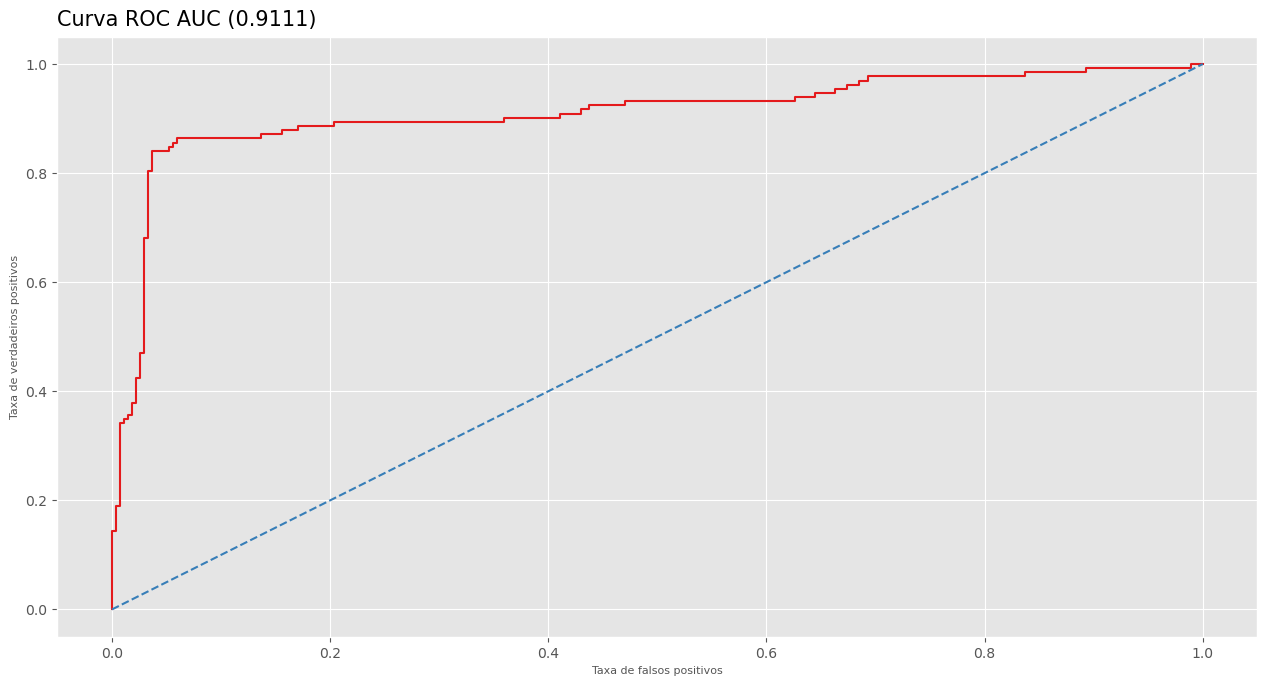

In [173]:
fig = plt.figure(figsize = (12, 6))
ax = fig.add_axes([0, 0, 1, 1])

plt.plot(curva[0], curva[1])
plt.plot([0, 1], [0, 1], '--')
ax.set_title(f"Curva ROC AUC ({metrics.roc_auc_score(y_test, y_proba):.4f})", 
             fontsize = 15, pad = 8, loc = 'left')
ax.set_xlabel("Taxa de falsos positivos", fontsize = 8)
ax.set_ylabel("Taxa de verdadeiros positivos", fontsize = 8)
plt.show()

O modelo tem bons resultados de acurácia e ROC AUC, além de boa sensibilidade e precisão que podem ser otimizados através de ajustes no limiar. Vamos explorar opções para ter o melhor F1 Score, que a métrica de equilibrio entre precisão e sensibilidade.

In [174]:
results = []

for thres in np.arange(0.05, 1, 0.05):
    
    y_predi = (clf.predict_proba(X_test)[:,1]>thres)
    precision = metrics.precision_score(y_test, y_predi)
    recall = metrics.recall_score(y_test, y_predi)
    f1 = metrics.f1_score(y_test, y_predi)
    
    
    results.append((thres, precision, recall, f1))

In [175]:
results = pd.DataFrame(results, columns=["thres", "precision", "recall", "f1"])
results

,thres,precision,recall,f1
0,0.05,0.489960,0.924242,0.640420
1,0.10,0.634409,0.893939,0.742138
2,0.15,0.741935,0.871212,0.801394
3,0.20,0.808511,0.863636,0.835165
4,0.25,0.832117,0.863636,0.847584
5,0.30,0.863636,0.863636,0.863636
6,0.35,0.875969,0.856061,0.865900
7,0.40,0.882812,0.856061,0.869231
8,0.45,0.888000,0.840909,0.863813
9,0.50,0.888000,0.840909,0.863813


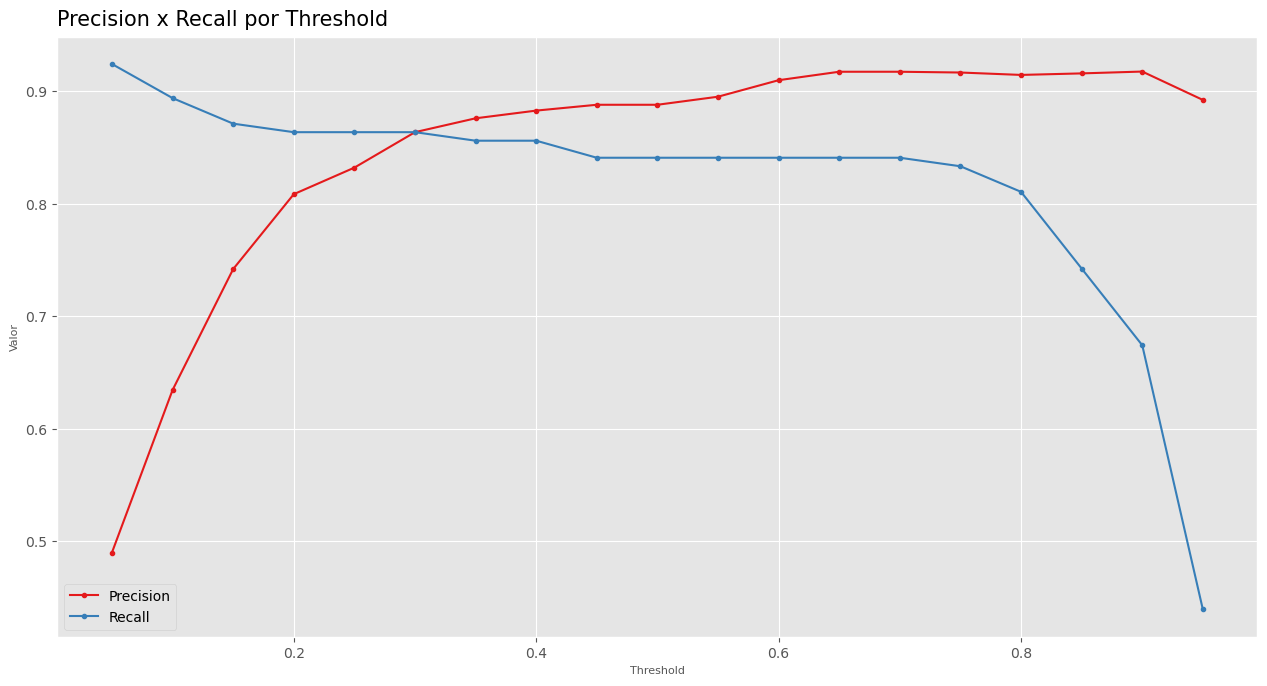

In [186]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_axes([0, 0, 1, 1])

plt.plot(results["thres"], results["precision"], label="Precision", marker='.')
plt.plot(results["thres"], results["recall"], label="Recall", marker='.')

ax.set_title("Precision x Recall por Threshold", fontsize = 15, pad = 8, loc = 'left')
ax.set_xlabel("Threshold", fontsize = 8)
ax.set_ylabel("Valor", fontsize = 8)
plt.legend()

plt.tight_layout()
plt.show()

In [187]:
y_pred_65 = (y_proba > 0.65).astype(int)

metric_report(y_test, y_pred_65)

{'Recall': 0.8409090909090909,
 'Precision': 0.9173553719008265,
 'F1 Score': 0.8774703557312253,
 'ROC AUC': 0.9019360269360269,
 'Accuracy': 0.9228855721393034}

In [188]:
print(metrics.classification_report(y_test, y_pred_65))

              precision    recall  f1-score   support

           0       0.93      0.96      0.94       270
           1       0.92      0.84      0.88       132

    accuracy                           0.92       402
   macro avg       0.92      0.90      0.91       402
weighted avg       0.92      0.92      0.92       402



In [189]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.95      0.94       270
           1       0.89      0.84      0.86       132

    accuracy                           0.91       402
   macro avg       0.91      0.89      0.90       402
weighted avg       0.91      0.91      0.91       402



Text(0.0, 1.0, 'Matriz de Confusão')

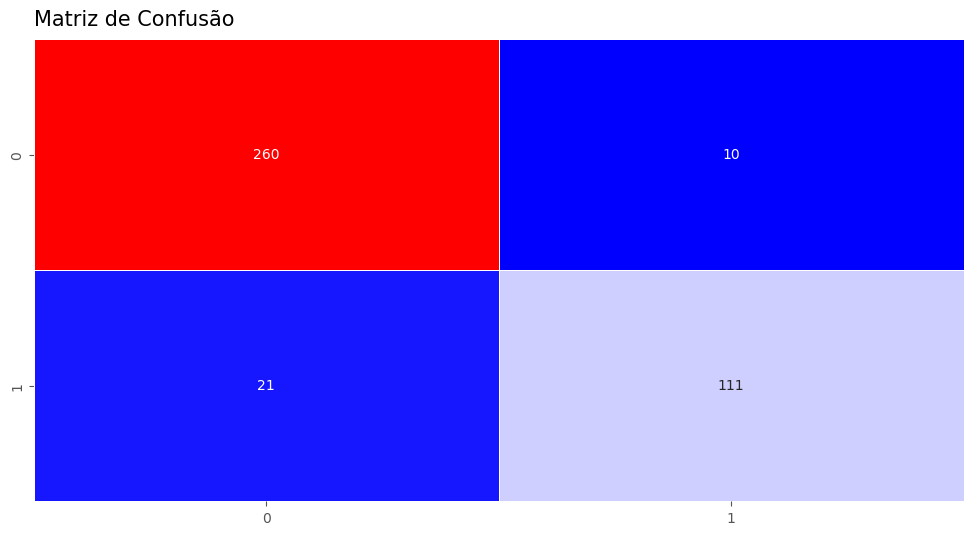

In [190]:
cf = metrics.confusion_matrix(y_test, y_pred_65)

fig, ax = plt.subplots(figsize = (12, 6))
sns.heatmap(cf, annot = True, fmt = '.0f', linewidths=0.5, cmap = 'bwr', cbar = False)
ax.set_title("Matriz de Confusão", fontsize = 15, pad= 10, loc = 'left')

Com o limiar ajustado para 0.65 temos uma melhora na precisão para as duas classes e apenas uma perca pequena na sensibilidade da classe 0. E assim temos o modelo com o limiar ideal. 

![periquito](https://github.com/datalopes1/pet_adoption/blob/main/doc/img/dim-hou-ZAtcN0f9HJc-unsplash.jpg?raw=true)